In [1]:
import numpy as np
from scipy.special import expit as sigmoid
from typing import List, Union, Callable
import sys
import matplotlib.pyplot as plt

In [2]:
X = np.identity(8)
y = X

In [5]:
def sigmoid_derivative(z: float) -> float:
    return sigmoid(z)*(1-sigmoid(z))

def quadratic_loss(predictions: np.ndarray, actuals: np.ndarray) -> np.ndarray:
    norms = np.apply_along_axis(np.linalg.norm, 0, predictions-actuals)
    return 0.5*np.apply_along_axis(np.power, 0, norms, 2)

def quadratic_loss_derivative(predictions: np.ndarray, actuals: np.ndarray) -> np.ndarray:
    return -(actuals-predictions)

def binary_crossentropy(predictions: np.ndarray, actuals: np.ndarray) -> np.ndarray:
    return actuals*np.log(predictions)+(np.ones(actuals.shape)-actuals)*np.log(np.ones(predictions.shape)-predictions)

def cost_function(loss_function: Callable, predictions: np.ndarray, actuals: np.ndarray, weights: List[np.ndarray], decay_parameter: float) -> float:
    avg_loss: float = np.mean(loss_function(predictions, actuals))
    sum_layers = [np.power(layer_weight, 2).sum() for layer_weight in weights]
    sum_all_weights = sum(sum_layers)
    regularization: float = 0.5*decay_parameter*sum_all_weights
    return avg_loss+regularization

class Layer:

    # declaration of instance variables
    weigths: np.ndarray
    has_bias: bool

    def __init__(self, num_nodes: int, num_nodes_n1: int, include_bias: bool = True, epsilon: float = 0.01) -> None:
        self.weights = np.random.normal(loc=0, scale=np.power(epsilon,2), size=(num_nodes_n1, np.add(num_nodes, include_bias)))
        self.has_bias = include_bias
    
    def print_weights(self) -> None:
        print(self.weights)


class Network:

    # declaration of instance variables
    layers: List[Layer]
    weights: List[np.ndarray]

    def __init__(self, num_nodes: List[int], include_biases: List[bool]) -> None:
        # num_nodes is a list of number of nodes for all layers not counting the bias node
        # TO-DO: code won't work if include_biases != [True, True, False], see prop_forward
        assert (include_biases == [True, True, False]), 'error when initializing Network class: include_bias parameter not available'

        self.layers = [Layer(num_nodes[i], num_nodes[i+1], include_biases[i]) for i in range(len(num_nodes)-1)]
        self.layers.append(Layer(num_nodes[-1], 0, include_biases[-1]))
        self.weights = self.get_weights(form='list')

    def get_weights(self, form: str = 'vector') -> Union[List[np.ndarray], np.ndarray]:
        assert (form in ['vector', 'list']), 'Error in get_weights function: form parameter ill-defined'

        if form == 'vector':
            # returns one np.ndarray with all weights of all layers
            weigth_vector = []
            for layer in self.layers:
                weigth_vector.append(layer.weights)
            return np.asarray(weigth_vector)
        elif form == 'list':
            # returns a list, where list[i] stores the weights between layer i-1 and layer i
            list_of_weights: List[np.ndarray] = []
            for layer in self.layers:
                list_of_weights.append(layer.weights)
            return list_of_weights

    def print_weights(self) -> None:
        print('Printing weights of network:')
        for index, layer in enumerate(self.layers):
            print(f'Layer {index+1}')
            layer.print_weights()

    def prop_forward(self, features: np.ndarray) -> List[np.ndarray]:
        # returns a list, where list[i] stores the activations for neurons in layer i+1
        # the activation of a bias node (should the layer have one) is given by the first value in the array and is always =1
        # TO-DO: right now it is hard coded that input layer & hidden layer have a bias node, but output layer has not
        z_2 = np.matmul(self.weights[0], np.append(1, features))
        a_2 = np.apply_along_axis(sigmoid, 0, z_2)
        z_3 = np.matmul(self.weights[1], np.append(1, a_2))
        a_3 = np.apply_along_axis(sigmoid, 0, z_3)
        return [np.append(1, features), np.append(1, a_2), a_3]

    def print_activations(self, features: np.ndarray) -> None:
        print(f'Printing activations for input: {features}')
        for index, array in enumerate(self.prop_forward(features)):
            print(f'Layer {index+1}: {array}')

    def calculate_z(self, num_layer: int, activations: List[np.ndarray]) -> float:
        z = np.dot(self.weights[num_layer-2], activations[num_layer-2])
        return np.dot(self.weights[num_layer-2], activations[num_layer-2])

    def get_deltas(self, X: np.ndarray, y: np.ndarray, loss_function_derivative: Callable, activations: List[np.ndarray]=None) -> List[np.ndarray]:
        # TO-DO: adapt code to accept different cost functions
        # Right now: hard coded to use quadratic loss
        if activations == None:
            activations = self.prop_forward(X)
        deltas = []
        # Fehler: activations != z!!!!
        # deltas_output = -np.multiply((y-activations[-1]), np.apply_along_axis(sigmoid_derivative, 0, activations[-1]))
        deltas_output = -np.multiply((y-activations[-1]), np.apply_along_axis(sigmoid_derivative, 0, self.calculate_z(3, activations)))
        deltas.insert(0, deltas_output)
        for i in range(len(activations)-2):
            # delta = np.multiply(np.matmul(np.transpose(self.weights[-(i+2)]), deltas[-(i+1)]), np.apply_along_axis(sigmoid_derivative, 0, activations[-2]))
            delta = np.multiply(np.matmul(np.transpose(self.weights[-(i+2)][:,1:]), deltas[-(i+1)]), np.apply_along_axis(sigmoid_derivative, 0, self.calculate_z((len(activations)-1-i), activations)))
            # remove 'bias delta', as activation of bias cannot be changed
            deltas.insert(0, delta)
        return deltas

    def partial_derivatives(self, X: np.ndarray, y: np.ndarray, verbose: bool =False) -> List[np.ndarray]:
        activations = self.prop_forward(X)
        deltas = self.get_deltas(X, y, activations)
        partial_derivatives = []
        for index in range(len(deltas)):
            if verbose:
                # for testing/debugging purposes
                print(f'Layer {index+1}: dimension deltas {index+2} {deltas[index].shape}, dimension activations {index+1} {activations[index].shape}')
                print(f'activations: {activations[index]}')
                print(f'deltas: {deltas[index]}')
            partial = np.outer(deltas[index], np.transpose(activations[index]))
            if verbose:
                # deltas should be equal to partial derivatives of the bias node
                print(f'Partial of bias: {partial[:,0]}')
            partial_derivatives.append(partial)
        return partial_derivatives

    def update_weights(self, big_delta: List[np.ndarray], regularization_parameter: float, learning_rate: float=0.01) -> None:
        for num_layer in range(len(self.weights)):
            self.weights[num_layer] = self.weights[num_layer]-learning_rate*(big_delta[num_layer] + regularization_parameter*self.weights[num_layer])

    def gradient_descent(self, X_train: np.ndarray, y_train: np.ndarray, regularization_parameter: float, learning_rate: float=0.01) -> None:
        big_delta: List[np.ndarray] = [] 
        for index in range(len(self.weights)):
            big_delta.append(np.zeros(self.weights[index].shape))
        for num_instance in range(X_train.shape[0]):
            partials = self.partial_derivatives(X[num_instance], y[num_instance])
            for num_layer in range(len(self.layers)-1):
                big_delta[num_layer] = big_delta[num_layer]+partials[num_layer]
        for num_layer in range(len(self.layers)):
            big_delta[num_layer] = (1/X_train.shape[0])*big_delta[num_layer]
        self.update_weights(big_delta, regularization_parameter, learning_rate)

    def train_network(self, n_iter: int, X_train: np.ndarray, y_train: np.ndarray, regul_param: float, learning_rate: float=0.01) -> None:
        # TO-DO: print/plot loss after each iteration 
        
        # calculate activation
        # loss based on activation
        costs = [[], []]
        for iter in range(n_iter):
            
            temp_costs = []            
            
            for instance in X_train:
                act_3 = self.prop_forward(instance)[2].reshape((8,1))
                # print('shape act_3: ', act_3.shape, ' shape weights_3: ', weights_3.shape)
                cos = cost_function(quadratic_loss, act_3, instance, self.weights, regul_param)
                temp_costs.append(cos)
                # print('predictions: ', act_3)
            costs[0].append(iter)
            costs[1].append(np.mean(temp_costs))
            self.gradient_descent(X_train, y_train, regularization_parameter=regul_param, learning_rate=learning_rate)
            
        
        plt.plot(costs[0], costs[1])
        plt.show()
        return None

In [ ]:
#test_network.print_weights()
#test_network.print_activations(X[0])
#print(test_network.get_deltas(X[0], X[0]))
#print(test_network.partial_derivatives(X[0], X[0], verbose=False)[0])
#test_network.gradient_descent(X, y, 1)

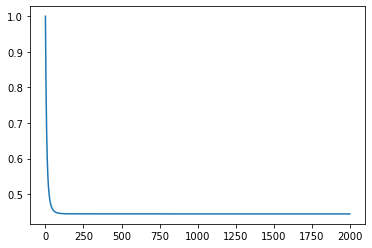

In [6]:
test_network = Network([8,3,8], [True, True, False])
test_network.train_network(2000, X, y, regul_param=0.001, learning_rate=0.5)

In [7]:
print(test_network.prop_forward(X[0]))

[array([1., 1., 0., 0., 0., 0., 0., 0., 0.]), array([1.        , 0.66868968, 0.6687367 , 0.668899  ]), array([0.13188984, 0.13189048, 0.13189055, 0.13189194, 0.13188964,
       0.13188975, 0.13189099, 0.13188936])]
